Egg Detection with DETR_Custom Dataset


In [1]:
# Importing libraries
from PIL import Image
import matplotlib.pyplot as plt
import os
import glob


import torch
import torchvision.transforms as T
from models import build_model

In [2]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

CLASSES = [
    'None',
    'Normal',
    'Crack',
    'Bleached',
    'Impurity',
    'Deformity',
    'Latent Crack',
    'N/A'
]

In [3]:
# Create arguments class for build DETR model
class Args:
    lr_backbone = 2e-4
    masks = None
    # Model parameters
    frozen_weights = None
    backbone = 'resnet50'
    dilation = False
    position_embedding = 'sine'
    enc_layers = 6
    dec_layers = 6
    dim_feedforward = 2048
    hidden_dim = 256
    dropout = 0.1
    nheads = 8
    num_queries = 100
    pre_norm = False
    aux_loss = False
    num_classes = 8
    set_cost_class=1
    set_cost_bbox=5
    set_cost_giou=2
    mask_loss_coef=1
    dice_loss_coef=1
    bbox_loss_coef=5
    giou_loss_coef=2
    eos_coef=0.1
    num_bbox_reg_classes = 2
    # Dataset parameters
    dataset_file = 'coco'
    coco_path = ''
    remove_difficult = False
    coco_panoptic_path = None
    # Device parameters
    device = 'cuda'
    seed = 42
    # Misc
    output_dir = ''
    resume = './outputs/best_Color.pth' # Path to load weights model


args = Args()

In [4]:
# Preprocess image - Get list of images
def collect_all_images(dir_test):
    """
    Function to return a list of image paths.

    :param dir_test: Directory containing images or single image path.

    Returns:
        test_images: List containing all image paths.
    """
    test_images = []
    if os.path.isdir(dir_test):
        image_file_types = ['*.jpg', '*.jpeg', '*.png', '*.ppm']
        for file_type in image_file_types:
            test_images.extend(glob.glob(f"{dir_test}/{file_type}"))
    else:
        test_images.append(dir_test)
    return test_images   

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_min, y_min, w, h = x.unbind(1)
    b = [x_min - 0.5 * w, y_min - 0.5 * h, x_min + 0.5 * w, y_min + 0.5 * h]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [15]:
# Compute distance between two points (x1, y1) and (x2, y2)
def distance(x, y):
    return ((x[0] - y[0])**2 + (x[1] - y[1])**2)**0.5

# Put everything on detect function
def detect(im, model, transform):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.8

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    #bboxes_scaled = bboxes_scaled.tolist()

    return probas[keep], bboxes_scaled

def Select_Bounding_Boxes(probas, bboxes_scaled):

    # Finding the center coordinates of the bounding box
    center_x = (bboxes_scaled[:, 0] + bboxes_scaled[:, 2]) / 2
    center_y = (bboxes_scaled[:, 1] + bboxes_scaled[:, 3]) / 2

    # Combine center_x and center_y to get the center coordinates
    center = torch.stack((center_x, center_y), dim=1)
    center = center.tolist()
    print(center)

    # Remove the center coordinates that are too close to each other
    dist = 0
    index_remove = []
    for i in range(len(center)):
        for j in range(i + 1, len(center)):
            dist = distance(center[i], center[j])
            if dist < 50:
                # Remove the center with the lower confidence
                if probas[i].max() > probas[j].max():
                    index_remove.append(j)
                else:
                    index_remove.append(i)

    print(index_remove)

    bboxes_scaled = bboxes_scaled.tolist()
    probas = probas.tolist()

    # Delete bounding boxes having index in index_remove
    # Sort index_remove in descending order
    index_remove.sort(reverse=True)
    for i in index_remove:
        del bboxes_scaled[i]
        del probas[i]
    
    # Convert list to tensor
    probas = torch.tensor(probas)
    return probas, bboxes_scaled


def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    pil_img = plt.imread(pil_img)
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes, COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

Detecting Eggs with DETR - DEMO with a Single Color Image


Number bounding boxes before:  11
[[810.1701049804688, 168.8841094970703], [313.2216796875, 178.34275817871094], [561.3335571289062, 503.7257080078125], [812.2950439453125, 170.01254272460938], [565.74462890625, 842.870361328125], [1050.0396728515625, 185.27288818359375], [564.22998046875, 180.0392303466797], [313.7327880859375, 858.5596923828125], [311.24957275390625, 537.8191528320312], [812.3231811523438, 495.9246826171875], [1057.63916015625, 834.929443359375]]
[3]
Number bounding boxes after:  10
10


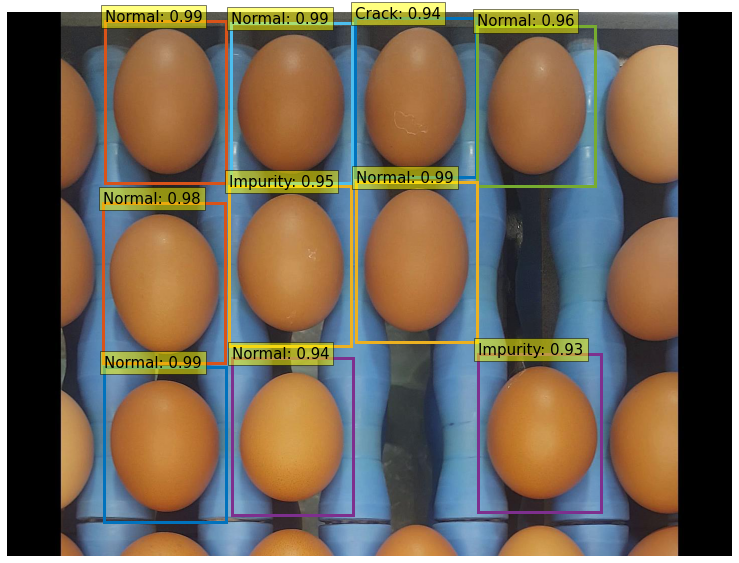

In [18]:
# Load model
model, criterion, postprocessors = build_model(args)
checkpoint = torch.load(args.resume, map_location='cpu')
model.load_state_dict(checkpoint['model'], strict=False)

# Inference phase visualization
#image = './20220919-02026.jpg'
image = './COLOR_Images_Demo/20220921-01003.jpg'
img = Image.open(image)
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


scores, boxes = detect(img, model, transform)
print('Number bounding boxes before: ', len(boxes))
scores_1, boxes_1 = Select_Bounding_Boxes(scores, boxes)
print('Number bounding boxes after: ', len(boxes_1))
plot_results(image, scores_1, boxes_1)


Detecting Eggs with DETR - DEMO with Multiple Color Images

Before:  10
[[217.24267578125, 874.2153930664062], [224.46417236328125, 209.1622314453125], [1233.724609375, 857.3184204101562], [979.63232421875, 189.29180908203125], [729.9532470703125, 882.3111572265625], [1224.747314453125, 230.16004943847656], [476.10589599609375, 848.041259765625], [981.3981323242188, 525.6502685546875], [982.8636474609375, 854.453857421875], [219.25367736816406, 551.9404907226562]]
[]
After:  10
10


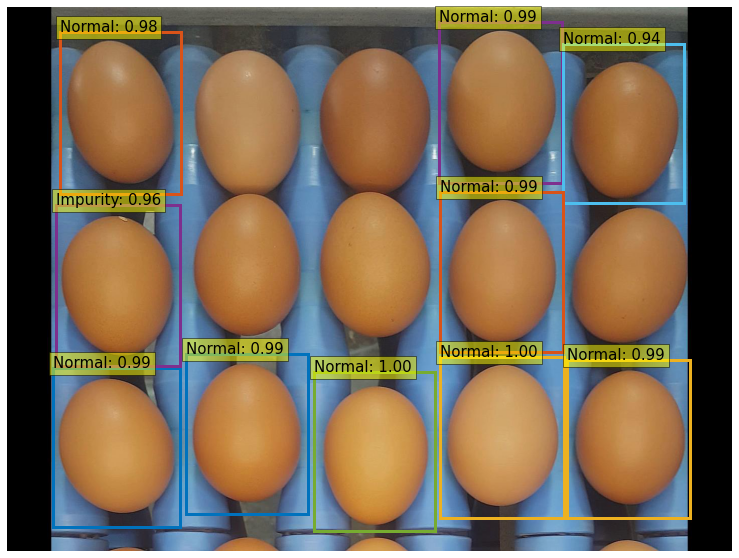

Before:  12
[[358.11895751953125, 205.5689239501953], [1108.790283203125, 862.8026123046875], [355.93756103515625, 544.2305908203125], [851.64013671875, 175.77621459960938], [607.518798828125, 855.3642578125], [607.4139404296875, 539.0240478515625], [1099.9796142578125, 178.79225158691406], [606.1953125, 214.84458923339844], [356.5126953125, 876.87890625], [854.6783447265625, 533.364501953125], [856.9290771484375, 840.4271850585938], [1103.190185546875, 535.6358642578125]]
[]
After:  12
12


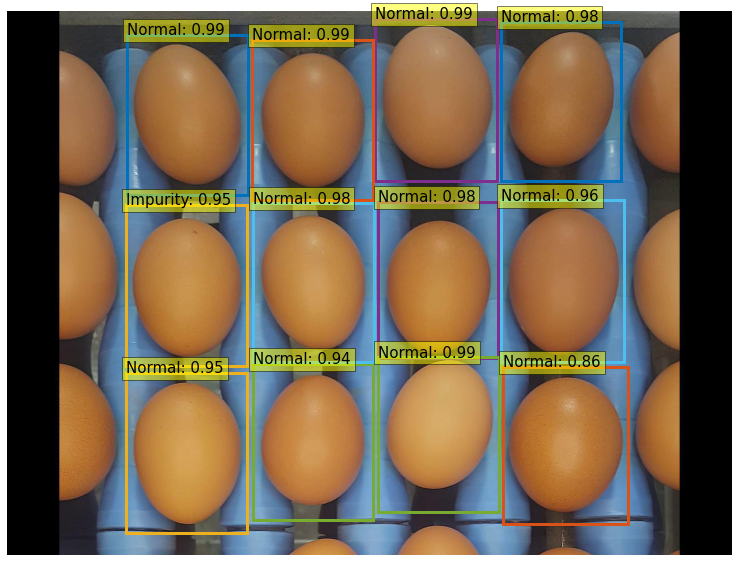

Before:  12
[[1068.5382080078125, 905.2964477539062], [823.937255859375, 239.38766479492188], [575.7532958984375, 906.5791015625], [573.310546875, 588.4898681640625], [1079.8074951171875, 249.89227294921875], [569.514892578125, 207.6583709716797], [315.85064697265625, 214.1802215576172], [328.36273193359375, 903.5667114257812], [320.802978515625, 585.8243408203125], [1071.705810546875, 587.8396606445312], [816.7803955078125, 912.2025756835938], [820.6312255859375, 597.208740234375]]
[]
After:  12
12


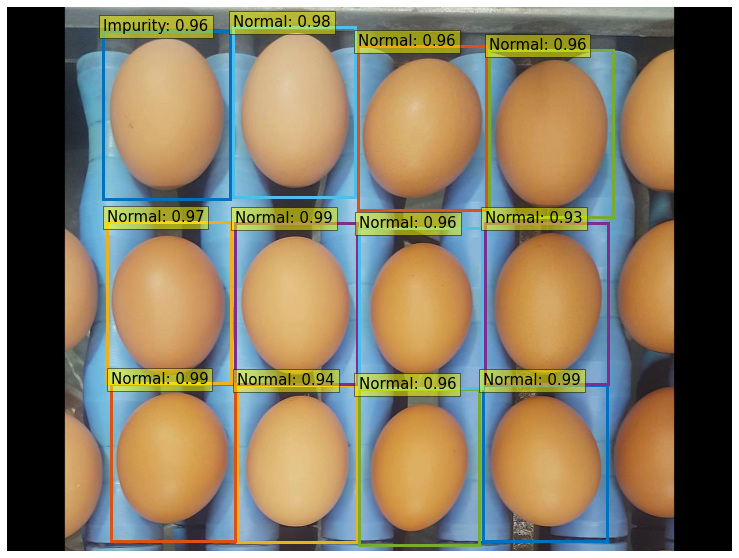

Before:  14
[[253.84503173828125, 824.026611328125], [262.6885986328125, 198.78126525878906], [724.193603515625, 537.5831298828125], [724.451904296875, 846.7821655273438], [953.5721435546875, 224.6057891845703], [724.3681030273438, 846.6077880859375], [724.6322021484375, 536.742431640625], [1178.4044189453125, 217.071044921875], [494.5255126953125, 219.42776489257812], [490.93218994140625, 522.326904296875], [489.2904357910156, 817.3587646484375], [254.96163940429688, 525.74462890625], [958.5068359375, 523.5523681640625], [725.9052734375, 233.0507049560547]]
[6, 3]
After:  12
12


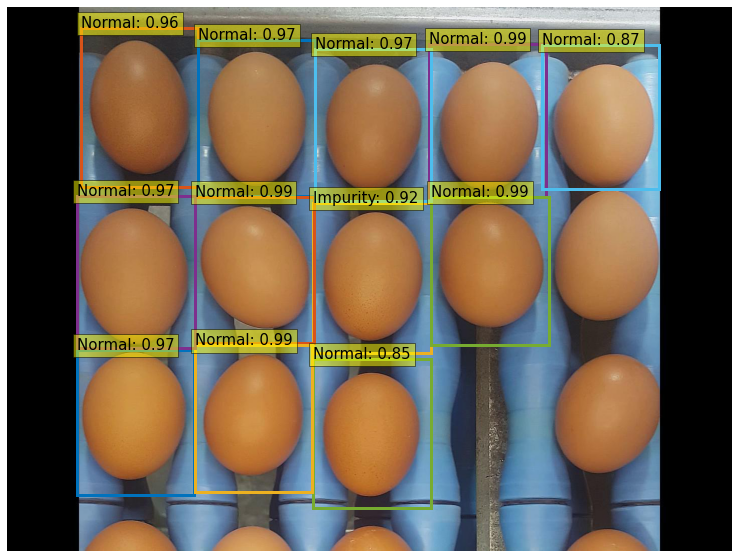

Before:  13
[[409.23480224609375, 197.2218475341797], [1172.09228515625, 907.5875244140625], [669.2662963867188, 553.8853759765625], [1184.670166015625, 186.61268615722656], [926.296630859375, 211.74395751953125], [670.7919921875, 888.7354125976562], [1184.5567626953125, 185.74449157714844], [667.7088623046875, 219.82191467285156], [412.96282958984375, 533.830322265625], [420.9716796875, 870.21435546875], [925.2091674804688, 573.944580078125], [921.170654296875, 900.2398681640625], [1179.629638671875, 538.1378784179688]]
[6]
After:  12
12


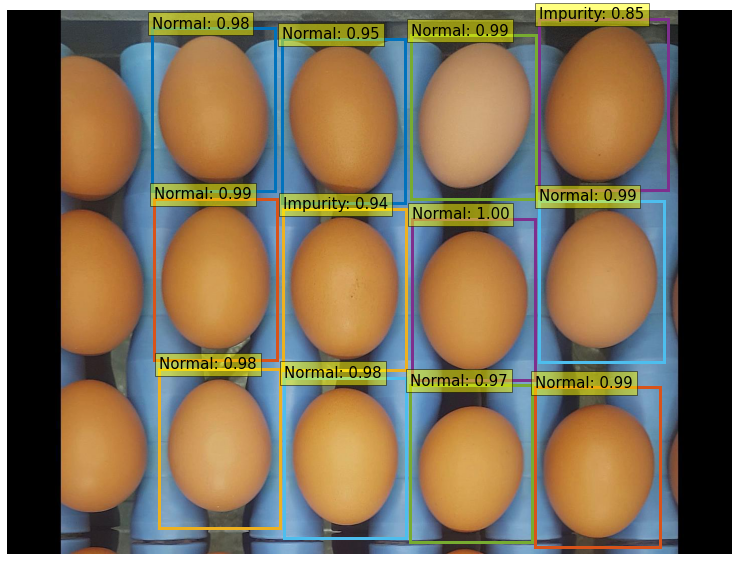

Before:  13
[[277.41058349609375, 896.26025390625], [788.4674072265625, 250.5270538330078], [533.2421875, 917.8533325195312], [270.34149169921875, 236.57406616210938], [1037.7186279296875, 921.9258422851562], [786.5159301757812, 584.3958129882812], [534.0985107421875, 916.597412109375], [783.8197021484375, 897.7274169921875], [786.3521728515625, 584.1257934570312], [1049.232177734375, 253.31265258789062], [275.00653076171875, 583.1607666015625], [1046.3944091796875, 593.7179565429688], [788.041748046875, 249.06463623046875]]
[12, 2, 5]
After:  10
10


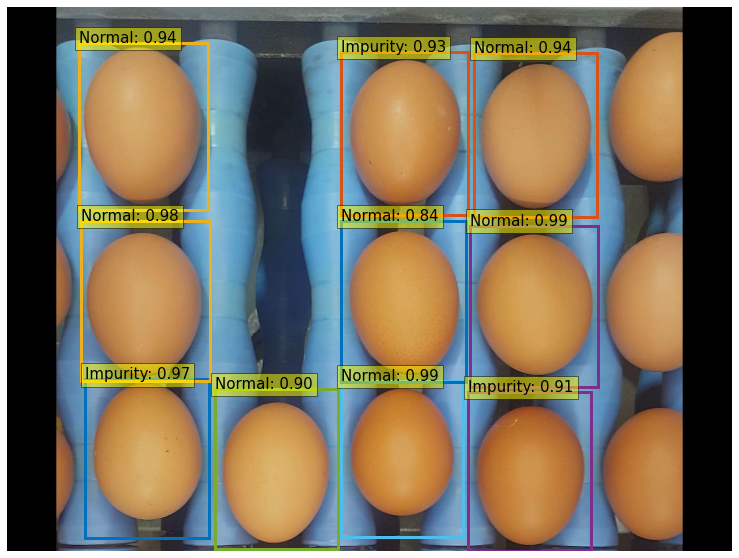

Before:  11
[[402.37249755859375, 886.8383178710938], [1157.2786865234375, 848.96142578125], [656.9489135742188, 555.1189575195312], [657.21337890625, 555.2367553710938], [1145.9886474609375, 207.47561645507812], [401.7564392089844, 556.0505981445312], [405.99169921875, 217.41783142089844], [401.34716796875, 887.8955078125], [905.0364990234375, 556.2427978515625], [902.3272094726562, 885.9183349609375], [903.227294921875, 886.668212890625]]
[7, 3, 9]
After:  8
8


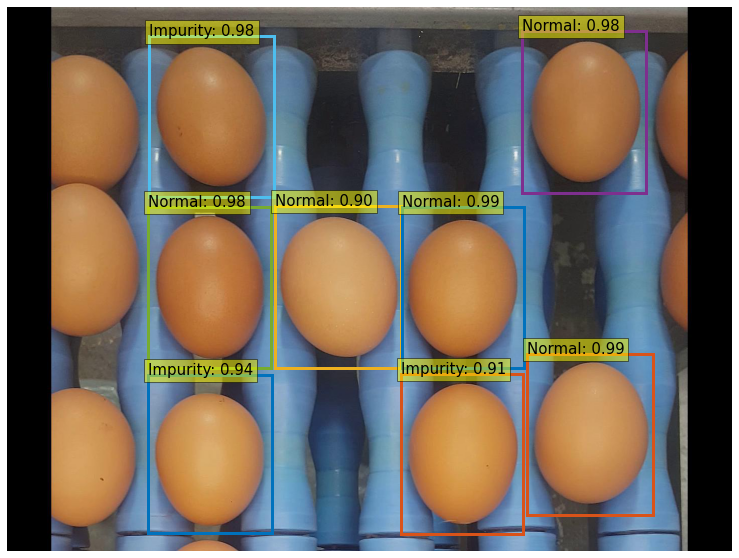

Before:  15
[[204.50315856933594, 885.3641357421875], [212.5137176513672, 187.8114776611328], [1224.3853759765625, 889.744873046875], [458.10858154296875, 514.0582885742188], [969.5972900390625, 199.42323303222656], [711.4577026367188, 879.8041381835938], [713.2784423828125, 542.8824462890625], [1222.4249267578125, 220.7154083251953], [462.6856384277344, 192.5684051513672], [457.3077697753906, 871.921142578125], [205.70770263671875, 549.2393798828125], [967.9588623046875, 528.5457153320312], [966.0291137695312, 885.969482421875], [1223.381103515625, 552.9781494140625], [715.8302001953125, 220.83193969726562]]
[]
After:  15
15


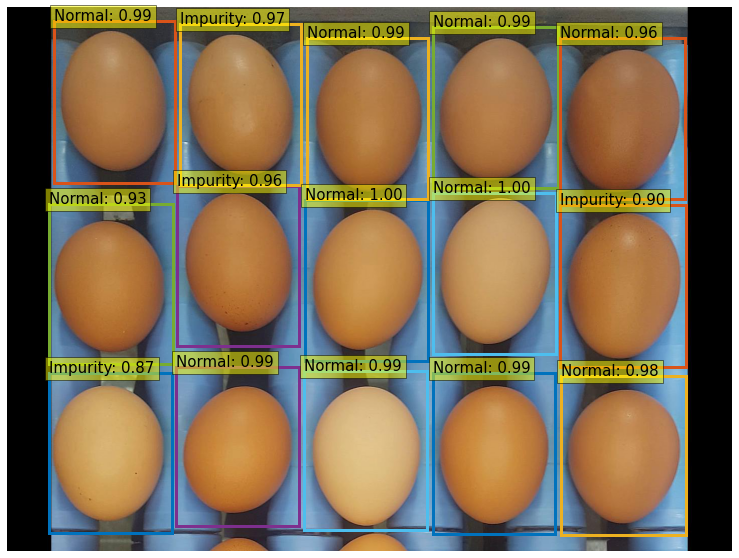

Before:  13
[[827.549072265625, 870.1502685546875], [329.124755859375, 189.61700439453125], [837.21240234375, 228.5582275390625], [581.9591674804688, 885.0685424804688], [583.1353759765625, 564.3410034179688], [1089.00146484375, 201.39491271972656], [582.8941650390625, 198.88243103027344], [332.3644714355469, 889.3876953125], [327.72174072265625, 522.077392578125], [1084.0338134765625, 538.1143188476562], [1077.3134765625, 871.6709594726562], [833.269287109375, 543.6837158203125], [1089.4512939453125, 200.9153594970703]]
[12]
After:  12
12


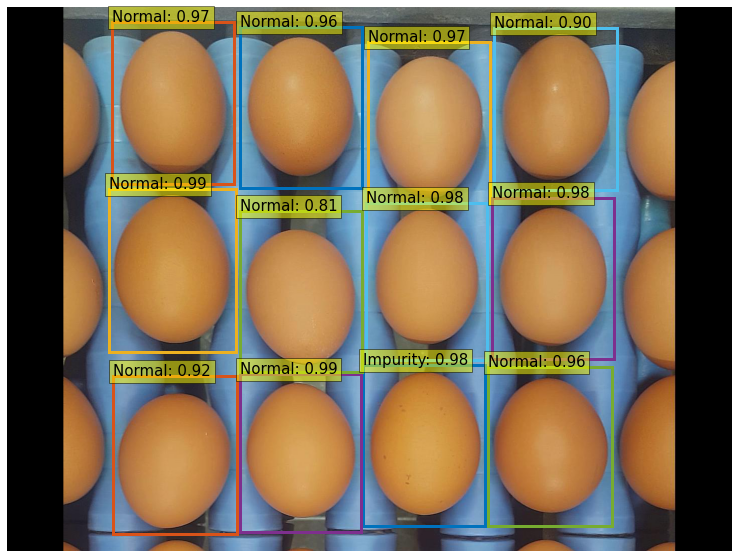

Before:  11
[[303.00836181640625, 230.8292236328125], [766.671875, 834.6925048828125], [531.3793334960938, 831.57177734375], [769.3638305664062, 202.30966186523438], [766.3340454101562, 533.7584228515625], [1000.59375, 234.81399536132812], [531.5278930664062, 194.71621704101562], [534.870849609375, 526.5148315429688], [297.792724609375, 844.7607421875], [299.6701354980469, 540.1766357421875], [1000.8797607421875, 538.7984008789062]]
[]
After:  11
11


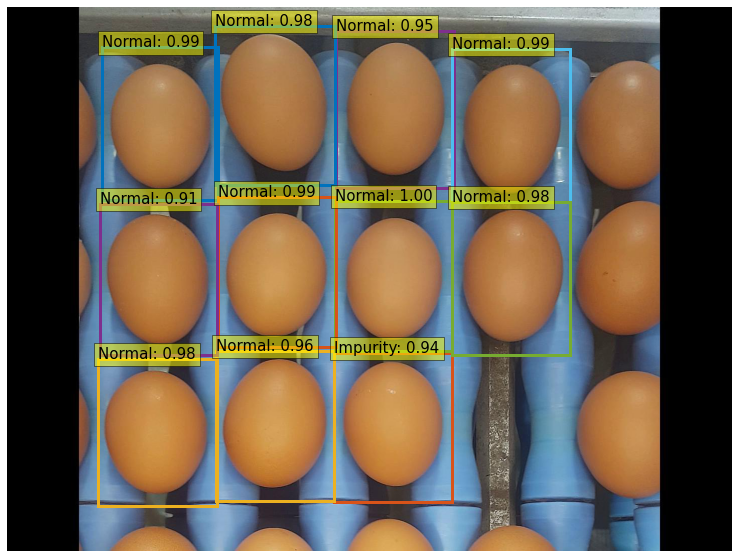

In [19]:
DIR_TEST = './COLOR_Images_Demo/'
test_images = collect_all_images(DIR_TEST)

count = 0

for image in test_images:
    if (count == 10):
        break
    img = Image.open(image)

    # Reset scores and boxes
    scores = []
    boxes = []
    

    scores, boxes = detect(img, model, transform)
    print('Before: ', len(boxes))
    scores_1, boxes_1 = Select_Bounding_Boxes(scores, boxes)
    print('After: ', len(boxes_1))
    plot_results(image, scores_1, boxes_1)  
    count += 1